In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import zipfile
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

# Scikit-learn
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, RFE
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.utils.class_weight import compute_class_weight

# XGBoost
from xgboost import XGBClassifier


In [ ]:
# Path to ZIP file
zip_path = "/content/drive/MyDrive/pcos/data/archive (1).zip"

# Extracting ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/pcos_dataset")  # Extract to a chosen folder

# STEP 3: Defining Excel file and sheet
excel_path = "/content/pcos_dataset/PCOS_data_without_infertility.xlsx"
sheet_name = "Full_new"

# STEP 4: Load data from sheet
df = pd.read_excel(excel_path, sheet_name=sheet_name)

print(df.head())

   Sl. No  Patient File No.  PCOS (Y/N)   Age (yrs)  Weight (Kg)  Height(Cm)   \
0       1                 1           0          28         44.6        152.0   
1       2                 2           0          36         65.0        161.5   
2       3                 3           1          33         68.8        165.0   
3       4                 4           0          37         65.0        148.0   
4       5                 5           0          25         52.0        161.0   

         BMI  Blood Group  Pulse rate(bpm)   RR (breaths/min)  ...  \
0  19.300000           15                78                22  ...   
1  24.921163           15                74                20  ...   
2  25.270891           11                72                18  ...   
3  29.674945           13                72                20  ...   
4  20.060954           11                72                18  ...   

   Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
0              1.0            

In [ ]:
# Load dataset
excel_path = "/content/pcos_dataset/PCOS_data_without_infertility.xlsx"
sheet_name = "Full_new"

df = pd.read_excel(excel_path, sheet_name=sheet_name)

# Separating numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns

# Initialize MICE imputer (MAR assumption: using other observed variables as predictors)
imputer = IterativeImputer(
    estimator=RandomForestRegressor(),  # Handles nonlinear medical data well
    max_iter=10,
    random_state=42
)

# Applying MICE to numeric columns
numeric_data_imputed = imputer.fit_transform(df[numeric_cols])

# Rebuild the DataFrame
df_imputed = pd.DataFrame(numeric_data_imputed, columns=numeric_cols)
df_final = pd.concat([df_imputed, df[non_numeric_cols].reset_index(drop=True)], axis=1)

# Save to Excel
output_path = "/content/drive/MyDrive/pcos/after_mice.xlsx"
df_final.to_excel(output_path, index=False)

print(f"✅ MICE imputation complete. File saved at: {output_path}")


✅ MICE imputation complete. File saved at: /content/drive/MyDrive/pcos/after_mice.xlsx


In [ ]:
# File paths
input_path = "/content/drive/MyDrive/pcos/after_mice.xlsx"
output_path = "/content/drive/MyDrive/pcos/ANOVA_pcos.xlsx"

# Read the dataset
df = pd.read_excel(input_path)

# Remove the unwanted column if it exists
if 'Unnamed: 44' in df.columns:
    df = df.drop(columns=['Unnamed: 44'])

# Target column
target_col = 'PCOS (Y/N)'

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Select only numeric features
X_numeric = X.select_dtypes(include=['float64', 'int64'])

# Perform ANOVA F-test
f_values, p_values = f_classif(X_numeric, y)

# Create a results dataframe
anova_df = pd.DataFrame({
    'Feature': X_numeric.columns,
    'F_Value': f_values,
    'p_Value': p_values
}).sort_values(by='p_Value', ascending=True)

# Save results
anova_df.to_excel(output_path, index=False)

print(f"ANOVA results saved to: {output_path}")


ANOVA results saved to: /content/drive/MyDrive/pcos/ANOVA_pcos.xlsx


In [ ]:
# File paths
input_path = "/content/drive/MyDrive/pcos/after_mice.xlsx"
output_path = "/content/drive/MyDrive/pcos/RFE_pcos.xlsx"

# Read the dataset
df = pd.read_excel(input_path)

# Remove the unwanted column if it exists
if 'Unnamed: 44' in df.columns:
    df = df.drop(columns=['Unnamed: 44'])

# Target column
target_col = 'PCOS (Y/N)'

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Select only numeric features
X_numeric = X.select_dtypes(include=['float64', 'int64'])

# Define the estimator (Logistic Regression commonly used for RFE with classification)
model = LogisticRegression(max_iter=500, solver='liblinear')

# Apply RFE (selecting all features, ranking will tell importance)
rfe = RFE(model, n_features_to_select=1)
rfe = rfe.fit(X_numeric, y)

# Create a results dataframe
rfe_df = pd.DataFrame({
    'Feature': X_numeric.columns,
    'Ranking': rfe.ranking_,
    'Selected': rfe.support_
}).sort_values(by='Ranking', ascending=True)

# Save results
rfe_df.to_excel(output_path, index=False)

print(f"RFE results saved to: {output_path}")


RFE results saved to: /content/drive/MyDrive/pcos/RFE_pcos.xlsx


In [ ]:

# File paths
input_path = "/content/drive/MyDrive/pcos/after_mice.xlsx"
output_path = "/content/drive/MyDrive/pcos/Lasso_pcos.xlsx"

# Read the dataset
df = pd.read_excel(input_path)

# Remove the unwanted column if it exists
if 'Unnamed: 44' in df.columns:
    df = df.drop(columns=['Unnamed: 44'])

# Target column
target_col = 'PCOS (Y/N)'

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Select only numeric features
X_numeric = X.select_dtypes(include=['float64', 'int64'])

# Perform Lasso with cross-validation to find best alpha
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_numeric, y)

# Extract coefficients
coef = pd.Series(lasso.coef_, index=X_numeric.columns)

# Create results dataframe
lasso_df = pd.DataFrame({
    'Feature': coef.index,
    'Coefficient': coef.values
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Save results
lasso_df.to_excel(output_path, index=False)

print(f"Lasso results saved to: {output_path}")


Lasso results saved to: /content/drive/MyDrive/pcos/Lasso_pcos.xlsx


In [ ]:
# File paths
anova_path = "/content/drive/MyDrive/pcos/ANOVA_pcos.xlsx"
data_path = "/content/drive/MyDrive/pcos/after_mice.xlsx"
output_path = "/content/drive/MyDrive/pcos/top25.xlsx"

# Step 1: Read ANOVA_pcos.xlsx and extract top 25 features
anova_df = pd.read_excel(anova_path)
top_features = anova_df["Feature"].head(25).tolist()

# Step 2: Read after_mice.xlsx
data_df = pd.read_excel(data_path)

# Step 3: Ensure 'Target' is kept, along with the top 25 features
selected_columns = ["Target"] + [f for f in top_features if f in data_df.columns]
final_df = data_df[selected_columns]

# Step 4: Save the filtered dataframe
final_df.to_excel(output_path, index=False)

print(f"File saved at: {output_path}")


File saved at: /content/drive/MyDrive/pcos/top25.xlsx


In [ ]:
# File paths
input_path = "/content/drive/MyDrive/pcos/top25.xlsx"
output_path = "/content/drive/MyDrive/pcos/standard_25.xlsx"

# Step 1: Read the top 25 features dataset
df = pd.read_excel(input_path)

# Step 2: Separate Target column from features
target = df["Target"]
features = df.drop(columns=["Target"])

# Step 3: Apply StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 4: Create a new DataFrame with standardized values
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# Step 5: Add Target back as the first column
final_df = pd.concat([target, scaled_df], axis=1)

# Step 6: Save the standardized dataset
final_df.to_excel(output_path, index=False)

print(f"Standardized file saved at: {output_path}")


Standardized file saved at: /content/drive/MyDrive/pcos/standard_25.xlsx


In [ ]:

# File paths
input_path = "/content/drive/MyDrive/pcos/standard_25.xlsx"
train_path = "/content/drive/MyDrive/pcos/train_25.xlsx"
test_path = "/content/drive/MyDrive/pcos/test_25.xlsx"

# Step 1: Load data
df = pd.read_excel(input_path)

# Step 2: Split into features (X) and target (y)
X = df.drop(columns=["Target"])
y = df["Target"]

# Step 3: Train-test split (use fixed random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Save train and test sets
train_df = pd.concat([y_train, X_train], axis=1)
test_df = pd.concat([y_test, X_test], axis=1)

train_df.to_excel(train_path, index=False)
test_df.to_excel(test_path, index=False)

print(f"Train file saved at: {train_path}")
print(f"Test file saved at: {test_path}")


Train file saved at: /content/drive/MyDrive/pcos/train_25.xlsx
Test file saved at: /content/drive/MyDrive/pcos/test_25.xlsx


In [ ]:
# File paths
train_path = "/content/drive/MyDrive/pcos/train_25.xlsx"
test_path = "/content/drive/MyDrive/pcos/test_25.xlsx"
model_path = "/content/drive/MyDrive/pcos/models/SVM/svm_model.pkl"

train_results_path = "/content/drive/MyDrive/pcos/models/SVM/train_results.csv"
test_results_path = "/content/drive/MyDrive/pcos/models/SVM/test_results.csv"
train_preds_path = "/content/drive/MyDrive/pcos/models/SVM/train_predictions.csv"
test_preds_path = "/content/drive/MyDrive/pcos/models/SVM/test_predictions.csv"
feature_importance_path = "/content/drive/MyDrive/pcos/models/SVM/feature_importance.csv"

# Load data
train_df = pd.read_excel(train_path)
test_df = pd.read_excel(test_path)

X_train, y_train = train_df.drop(columns=["Target"]), train_df["Target"]
X_test, y_test = test_df.drop(columns=["Target"]), test_df["Target"]

# Handle class imbalance with class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Hyperparameter tuning with Stratified CV
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", "auto"],
    "kernel": ["linear", "rbf"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    SVC(class_weight=class_weights, probability=True, random_state=42),
    param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_
print(" Best parameters found:", grid_search.best_params_)

# Save model
joblib.dump(best_svm, model_path)

# Predictions
y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)

y_train_prob = best_svm.predict_proba(X_train)[:, 1]
y_test_prob = best_svm.predict_proba(X_test)[:, 1]

# Save prediction files
pd.DataFrame({
    "True": y_train,
    "Predicted": y_train_pred,
    "Probability": y_train_prob
}).to_csv(train_preds_path, index=False)

pd.DataFrame({
    "True": y_test,
    "Predicted": y_test_pred,
    "Probability": y_test_prob
}).to_csv(test_preds_path, index=False)

# Save result metrics (ONLY Accuracy, Precision, ROC-AUC)
train_metrics = {
    "Accuracy": accuracy_score(y_train, y_train_pred),
    "Precision": precision_score(y_train, y_train_pred, zero_division=0),
    "ROC_AUC": roc_auc_score(y_train, y_train_prob)
}
test_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred, zero_division=0),
    "ROC_AUC": roc_auc_score(y_test, y_test_prob)
}

pd.DataFrame([train_metrics]).to_csv(train_results_path, index=False)
pd.DataFrame([test_metrics]).to_csv(test_results_path, index=False)

# Print results in terminal
print("\n Training Results:")
print(f"Accuracy: {train_metrics['Accuracy']:.4f}")
print(f"ROC-AUC : {train_metrics['ROC_AUC']:.4f}")

print("\n Testing Results:")
print(f"Accuracy: {test_metrics['Accuracy']:.4f}")
print(f"ROC-AUC : {test_metrics['ROC_AUC']:.4f}")

# Feature Importance (only for linear kernel)
if best_svm.kernel == "linear":
    importance = pd.DataFrame({
        "Feature": X_train.columns,
        "Coefficient": best_svm.coef_[0]
    }).sort_values(by="Coefficient", key=abs, ascending=False)
    importance.to_csv(feature_importance_path, index=False)
else:
    importance = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": np.var(X_train, axis=0)
    }).sort_values(by="Importance", ascending=False)
    importance.to_csv(feature_importance_path, index=False)

print("\n Training finished and all files saved successfully!")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best parameters found: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

📊 Training Results:
Accuracy: 0.9144
ROC-AUC : 0.9652

📊 Testing Results:
Accuracy: 0.9174
ROC-AUC : 0.9589

✅ Training finished and all files saved successfully!


In [ ]:
# File paths
base_dir = "/content/drive/MyDrive/pcos/models/LR"
os.makedirs(base_dir, exist_ok=True)   # make directory if not exists

PATH = "/content/drive/MyDrive/pcos/standard_25.xlsx"
model_path = f"{base_dir}/lr_model.pkl"

train_results_path = f"{base_dir}/train_results.csv"
test_results_path  = f"{base_dir}/test_results.csv"
train_preds_path   = f"{base_dir}/train_predictions.csv"
test_preds_path    = f"{base_dir}/test_predictions.csv"
feature_importance_path = f"{base_dir}/feature_importance.csv"

# Load data
df = pd.read_excel(PATH)
y = df["Target"].values
X = df.drop(columns=["Target"])

# Train/test split (stratified)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Hyperparameter tuning
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"],
    "class_weight": [None, "balanced"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    LogisticRegression(max_iter=2000),
    param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)
grid.fit(X_tr, y_tr)
best_lr = grid.best_estimator_
print(" Best parameters found:", grid.best_params_)

# Save model
joblib.dump(best_lr, model_path)

# Predictions
y_tr_pred = best_lr.predict(X_tr)
y_te_pred = best_lr.predict(X_te)

y_tr_prob = best_lr.predict_proba(X_tr)[:, 1]
y_te_prob = best_lr.predict_proba(X_te)[:, 1]

# Save prediction files
pd.DataFrame({
    "True": y_tr,
    "Predicted": y_tr_pred,
    "Probability": y_tr_prob
}).to_csv(train_preds_path, index=False)

pd.DataFrame({
    "True": y_te,
    "Predicted": y_te_pred,
    "Probability": y_te_prob
}).to_csv(test_preds_path, index=False)

# Metrics (Accuracy, Precision, ROC-AUC)
train_metrics = {
    "Accuracy": accuracy_score(y_tr, y_tr_pred),
    "Precision": precision_score(y_tr, y_tr_pred, zero_division=0),
    "ROC_AUC": roc_auc_score(y_tr, y_tr_prob)
}
test_metrics = {
    "Accuracy": accuracy_score(y_te, y_te_pred),
    "Precision": precision_score(y_te, y_te_pred, zero_division=0),
    "ROC_AUC": roc_auc_score(y_te, y_te_prob)
}

pd.DataFrame([train_metrics]).to_csv(train_results_path, index=False)
pd.DataFrame([test_metrics]).to_csv(test_results_path, index=False)

# Print results in terminal
print("\n Training Results:")
print(f"Accuracy : {train_metrics['Accuracy']:.4f}")
print(f"ROC-AUC  : {train_metrics['ROC_AUC']:.4f}")

print("\n Testing Results:")
print(f"Accuracy : {test_metrics['Accuracy']:.4f}")
print(f"ROC-AUC  : {test_metrics['ROC_AUC']:.4f}")

# Feature Importance (coefficients)
coef = pd.Series(best_lr.coef_[0], index=X.columns)
importance = (
    pd.DataFrame({
        "Feature": coef.index,
        "Coefficient": coef.values,
        "Abs_Coefficient": np.abs(coef.values)
    })
    .sort_values("Abs_Coefficient", ascending=False)
)
importance.to_csv(feature_importance_path, index=False)

print("\n✅ Training finished and all files saved successfully!")


✅ Best parameters found: {'C': 0.01, 'class_weight': None, 'solver': 'lbfgs'}

📊 Training Results:
Accuracy : 0.8912
ROC-AUC  : 0.9627

📊 Testing Results:
Accuracy : 0.8716
ROC-AUC  : 0.9444

✅ Training finished and all files saved successfully!


In [ ]:
# File paths
train_path = "/content/drive/MyDrive/pcos/train_25.xlsx"
test_path = "/content/drive/MyDrive/pcos/test_25.xlsx"

output_dir = "/content/drive/MyDrive/pcos/models/XGBoost"
os.makedirs(output_dir, exist_ok=True)

train_results_path = os.path.join(output_dir, "train_results.csv")
test_results_path = os.path.join(output_dir, "test_results.csv")
train_preds_path = os.path.join(output_dir, "train_predictions.csv")
test_preds_path = os.path.join(output_dir, "test_predictions.csv")
feature_importance_path = os.path.join(output_dir, "feature_importance.csv")

# Load data
train_df = pd.read_excel(train_path)
test_df = pd.read_excel(test_path)

X_train, y_train = train_df.drop(columns=["Target"]), train_df["Target"]
X_test, y_test = test_df.drop(columns=["Target"]), test_df["Target"]

# Handle class imbalance (scale_pos_weight)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Hyperparameter tuning with Stratified CV

param_grid = {
    "n_estimators": [100, 200],        # fewer trees
    "max_depth": [3, 4],              # shallower trees
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "scale_pos_weight": [1, class_ratio],
    "reg_lambda": [10, 20, 50],       # stronger L2 regularization
    "reg_alpha": [5, 10, 20]          # stronger L1 regularization
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)
# Fit the model
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
y_train_prob = best_model.predict_proba(X_train)[:, 1]
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Save result metrics (ONLY Accuracy & ROC-AUC)
train_metrics = {
    "Accuracy": accuracy_score(y_train, y_train_pred),
    "ROC_AUC": roc_auc_score(y_train, y_train_prob)
}
test_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "ROC_AUC": roc_auc_score(y_test, y_test_prob)
}

pd.DataFrame([train_metrics]).to_csv(train_results_path, index=False)
pd.DataFrame([test_metrics]).to_csv(test_results_path, index=False)

# Save prediction files
pd.DataFrame({
    "True": y_train,
    "Predicted": y_train_pred,
    "Probability": y_train_prob
}).to_csv(train_preds_path, index=False)

pd.DataFrame({
    "True": y_test,
    "Predicted": y_test_pred,
    "Probability": y_test_prob
}).to_csv(test_preds_path, index=False)

# Save trained model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = os.path.join(output_dir, f"XGBoost_best_model_{timestamp}.pkl")
joblib.dump(best_model, model_filename)
print(f"Saved best model to {model_filename}")

# Feature Importance
importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)
importance.to_csv(feature_importance_path, index=False)

# Print results in terminal
print("\n Training Results:")
print(f"Accuracy: {train_metrics['Accuracy']:.4f}")
print(f"ROC-AUC : {train_metrics['ROC_AUC']:.4f}")

print("\n Testing Results:")
print(f"Accuracy: {test_metrics['Accuracy']:.4f}")
print(f"ROC-AUC : {test_metrics['ROC_AUC']:.4f}")

print("\n Training finished and all files saved successfully in:", output_dir)


🚀 Starting Grid Search...
Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:02:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 5, 'reg_lambda': 10, 'scale_pos_weight': np.float64(2.0638297872340425), 'subsample': 0.7}
✅ Saved best model to /content/drive/MyDrive/pcos/models/XGBoost/XGBoost_best_model_20250831_180240.pkl

📊 Training Results:
Accuracy: 0.9676
ROC-AUC : 0.9922

📊 Testing Results:
Accuracy: 0.8991
ROC-AUC : 0.9444

✅ Training finished and all files saved successfully in: /content/drive/MyDrive/pcos/models/XGBoost


In [ ]:
# Load the data
train_path = "/content/drive/MyDrive/pcos/train_25.xlsx"
test_path = "/content/drive/MyDrive/pcos/test_25.xlsx"

save_dir = "/content/drive/MyDrive/pcos/models/MLP"
os.makedirs(save_dir, exist_ok=True)

train_df = pd.read_excel(train_path)
test_df = pd.read_excel(test_path)

X_train = train_df.drop(columns=['Target'])
y_train = train_df['Target']

X_test = test_df.drop(columns=['Target'])
y_test = test_df['Target']

# Define model and parameter grid
mlp = MLPClassifier(max_iter=1000, random_state=42)

param_grid = {
    "hidden_layer_sizes": [(50,), (100,), (50,50), (100,50)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "alpha": [0.0001, 0.001, 0.01],  # L2 regularization
    "learning_rate": ["constant", "adaptive"]
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring="accuracy",   # can change to 'roc_auc'
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit
print("Starting Grid Search for MLP...")
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Evaluate
def evaluate_and_save(model, X, y, split_name):
    preds = model.predict(X)
    probs = model.predict_proba(X)[:, 1]  # probability of positive class

    acc = accuracy_score(y, preds)
    roc = roc_auc_score(y, probs)  # use probabilities, not hard labels

    print(f"\n {split_name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC : {roc:.4f}")

    # Save metrics
    metrics = {"Accuracy": acc, "ROC-AUC": roc}
    pd.DataFrame([metrics]).to_csv(os.path.join(save_dir, f"{split_name.lower()}_results.csv"), index=False)

    # Save predictions + probabilities
    pd.DataFrame({
        "True": y,
        "Predicted": preds,
        "Probability": probs
    }).to_csv(os.path.join(save_dir, f"{split_name.lower()}_predictions.csv"), index=False)

    return metrics

train_metrics = evaluate_and_save(best_model, X_train, y_train, "Train")
test_metrics = evaluate_and_save(best_model, X_test, y_test, "Test")

# Save model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = os.path.join(save_dir, f"MLP_best_model_{timestamp}.pkl")
joblib.dump(best_model, model_filename)
print(f"\n Saved best MLP model to {model_filename}")

print("\n Training finished! All results, predictions, and model are saved in:", save_dir)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/pcos/train_25.xlsx'

In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/pcos/models/LR/test_results.csv"
df = pd.read_csv(file_path)

print(df.head())       # show first few rows
print(df.columns)      # show all column names


   Accuracy  Precision   ROC_AUC
0   0.87156   0.892857  0.944444
Index(['Accuracy', 'Precision', 'ROC_AUC'], dtype='object')


In [ ]:

file_path = "/content/drive/MyDrive/pcos/models/LR/test_predictions.csv"
df = pd.read_csv(file_path)

print(df.head())       # first few rows
print(df.columns)      # all column names


   True  Predicted  Probability
0     1          0     0.089029
1     0          0     0.295187
2     0          0     0.214534
3     1          1     0.749157
4     0          0     0.095361
Index(['True', 'Predicted', 'Probability'], dtype='object')


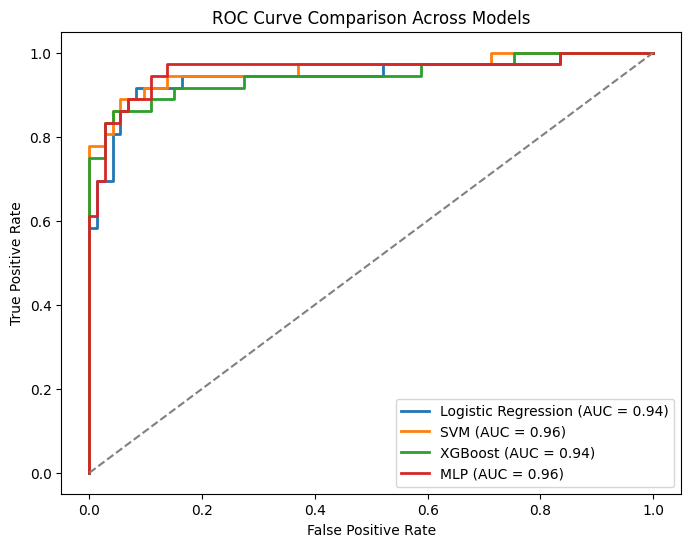

In [ ]:
# Define model names and file paths
models = {
    "Logistic Regression": "/content/drive/MyDrive/pcos/models/LR/test_predictions.csv",
    "SVM": "/content/drive/MyDrive/pcos/models/SVM/test_predictions.csv",
    "XGBoost": "/content/drive/MyDrive/pcos/models/XGBoost/test_predictions.csv",
    "MLP": "/content/drive/MyDrive/pcos/models/MLP/test_predictions.csv"
}

plt.figure(figsize=(8, 6))

for model_name, file_path in models.items():
    df = pd.read_csv(file_path)

    # Find probability column (case-insensitive)
    prob_col = None
    for col in df.columns:
        if "prob" in col.lower():
            prob_col = col
            break

    if prob_col is None:
        print(f"⚠️ No probability column found for {model_name}, skipping...")
        continue

    y_true = df["True"]
    y_prob = df[prob_col]

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Random baseline
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison Across Models")
plt.legend(loc="lower right")
plt.show()
